In [2]:
# run multiple reps with no dinucleotide present

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyemma as py
import scipy
import sys, os

import math
import glob 

import MDAnalysis as mda
import nglview as ng
from nglview import NGLWidget
import mdtraj as md

from MDAnalysis import transformations

from sklearn.decomposition import PCA

from MDAnalysis.analysis import rms
from MDAnalysis.analysis import distances

/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [3]:
# print trjconv commands for each new job

# file path
#mj_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/'
mj_path = './gap_md/'

# list of different gap sizes
cmd_list = []
job_list = sorted(glob.glob(f'{mj_path}*_CT*TC_*/'))

for job_dir in job_list:
    cmd_list.append(f'cd {job_dir}')
    cmd_list.append('echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc whole')
    cmd_list.append('echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000')
        
for cmd in cmd_list:
    print(cmd)
print('\n\n')

cd ./gap_md/2000ns_310K_CTTC_BSC1_DNA_rep1/
echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc whole
echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000
cd ./gap_md/2000ns_310K_CTTTC_BSC1_DNA_rep1/
echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc whole
echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000
cd ./gap_md/2000ns_310K_CTTTTC_BSC1_DNA_rep1/
echo "DNA" | gmx trjconv -s md.tpr -f md.xtc -o md_nosolv.xtc -pbc whole
echo "DNA" | gmx trjconv -f md.xtc -s md.tpr -o md_nosolv.pdb -skip 100000





./gap_md/2000ns_310K_CTTC_BSC1_DNA_rep1/md_nosolv.pdb
./gap_md/2000ns_310K_CTTC_BSC1_DNA_rep1/md_nosolv.xtc (6440, 123, 3)
(6440, 3)
./gap_md/2000ns_310K_CTTTC_BSC1_DNA_rep1/md_nosolv.pdb
./gap_md/2000ns_310K_CTTTC_BSC1_DNA_rep1/md_nosolv.xtc (6337, 155, 3)
(6337, 3)
./gap_md/2000ns_310K_CTTTTC_BSC1_DNA_rep1/md_nosolv.pdb
./gap_md/2000ns_310K_CTTTTC_BSC1_DNA_rep1/md_nosolv.xtc (6152, 187, 3)
(6152, 3)
2000ns_310K_gap_BSC1_DNA_rep1 (2389, 817, 3)
2000ns_310K_gap_BSC1_DNA_rep2 (2452, 817, 3)
2000ns_310K_gap_BSC1_DNA_rep3 (2455, 817, 3)
2000ns_310K_gap_BSC1_DNA_rep4 (2006, 817, 3)
2000ns_310K_gap_BSC1_DNA_rep5 (2392, 817, 3)
2000ns_310K_gap_AAA_BSC1_DNA_ (2192, 849, 3)
2000ns_310K_gap_AAA_BSC1_DNA_rep1 (2246, 849, 3)
2000ns_310K_gap_AAA_BSC1_DNA_rep2 (2283, 849, 3)
2000ns_310K_gap_AAA_BSC1_DNA_rep3 (2271, 849, 3)
2000ns_310K_gap_AAA_BSC1_DNA_rep4 (2129, 849, 3)
2000ns_310K_gap_AAAA_BSC1_DNA_ (2047, 881, 3)
2000ns_310K_gap_AAAA_BSC1_DNA_rep1 (1963, 881, 3)
2000ns_310K_gap_AAAA_BSC1_DNA_rep

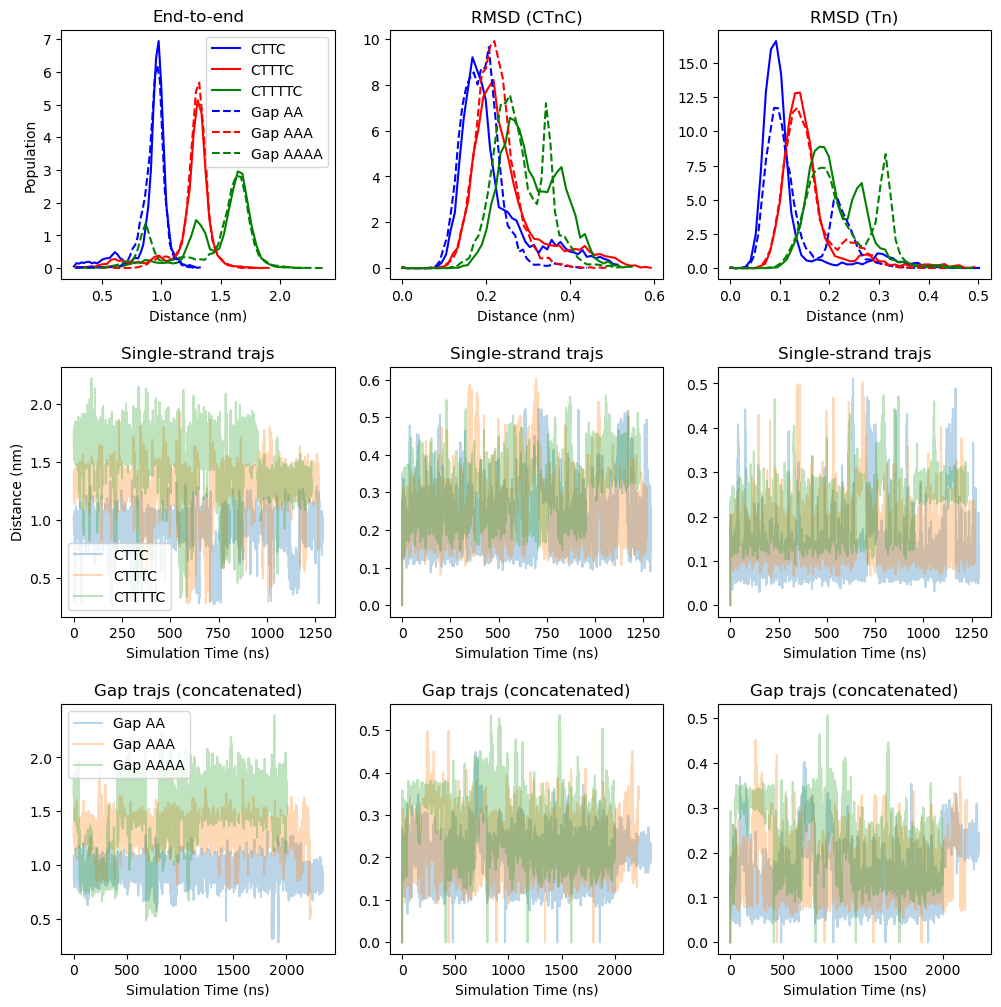

In [7]:
## end to end distance for each gap
from pyemma.coordinates import featurizer

# set up shared axes for gap and ss-strand
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
cv_labels = ['End-to-end', 'RMSD (CTnC)', 'RMSD (Tn)']
color_list = ['blue', 'red', 'green']
nbins = 50
save_npys = True

## single strand first

# list of different gap sizes
gap_names = ['CTTC', 'CTTTC', 'CTTTTC']
c5 = 30
c3_list = [92, 124, 156]

# currently redundant as assumes more than one traj per category
for gap, c3, color in zip(gap_names, c3_list, color_list):
    nbp = len(gap)
    
    pdb = glob.glob(f'{mj_path}*{gap}*/md_nosolv.pdb')[0]
    xtc_list = sorted(glob.glob(f'{mj_path}*{gap}*/md_nosolv.xtc'))
    print(pdb)

    # featurize with residue dists
    feat = featurizer(pdb)
    pair_list = [[0, nbp-1]]
    feat.add_residue_mindist(residue_pairs=pair_list)
    feat.add_minrmsd_to_ref(pdb, ref_frame=0)
    feat.add_minrmsd_to_ref(pdb, ref_frame=0, atom_indices=np.arange(c5, c3))

    # load each traj object
    traj_list, feat_list = [], []
    for xtc in xtc_list:

        traj = md.load(xtc, top=pdb) 
        print(xtc, traj.xyz.shape)
        traj_list.append(traj)

        feats = feat.transform(traj)
        feat_list.append(feats)
        print(np.shape(feats)) 
        
    feats = np.concatenate(feat_list)
    for i, (cv, ax) in enumerate(zip(cv_labels, axes.T)):
        
        # plot hist of concatenated feats
        h, b = np.histogram(feats[:, i], bins=50, density=True)
        ax[0].plot(b[:-1], h, label=gap, c=color)
        ax[0].set_title(cv)
        ax[0].set_xlabel('Distance (nm)')
        
        # plot feats over time
        x = 0.2 * np.arange(len(feats[:, i]))
        ax[1].plot(x, feats[:, i], label=gap, alpha=0.3)
        ax[1].set_xlabel('Simulation Time (ns)')
        ax[1].set_title('Single-strand trajs')
        
        if save_npys:
            np.save(f'./npys/{gap}-{cv}', feats[:, i])
    
## now to the gapped sequebces 

gap_list = ['gap_B', 'gap_AAA_B', 'gap_AAAA_B']
gap_names = ['AA', 'AAA', 'AAAA']

nbp_list = [14, 15, 16]
ngap_list = [2, 3, 4]
c5 = 566
c3_list = [630, 662, 694]

for gap, gap_name, nbp, ngap, c3, color in zip(
    gap_list, gap_names, nbp_list, ngap_list, c3_list, color_list):
    
    pdb = glob.glob(f'{mj_path}*{gap}*/md_nosolv.pdb')[0]
    xtc_list = sorted(glob.glob(f'{mj_path}*{gap}*/md_nosolv.xtc'))

    # featurize with residue dists
    feat = featurizer(pdb)
    #pair_list = [[0, nbp-ngap-1], [5, 6], [nbp-ngap, nbp*2-ngap-1], [nbp-ngap+5, nbp+6]]
    pair_list = [[nbp-ngap+5, nbp+6]]
    feat.add_residue_mindist(residue_pairs=pair_list)
    feat.add_minrmsd_to_ref(pdb, ref_frame=0, atom_indices=np.arange(c5-30, c3+30))
    feat.add_minrmsd_to_ref(pdb, ref_frame=0, atom_indices=np.arange(c5, c3))

    # load each traj object
    traj_list, feat_list = [], []
    for xtc in xtc_list:

        traj = md.load(xtc, top=pdb) 
        print(xtc.split('/')[2], traj.xyz.shape)
        traj_list.append(traj)

        feats = feat.transform(traj)
        feat_list.append(feats)
        #print(np.shape(feats)) 
        
    feats = np.concatenate(feat_list)
    for i, (cv, ax) in enumerate(zip(cv_labels, axes.T)):
        
        # plot hist of concatenated feats
        h, b = np.histogram(feats[:, i], bins=50, density=True)
        ax[0].plot(b[:-1], h, label=f'Gap {gap_name}', linestyle='dashed', c=color)
        ax[0].set_title(cv)
        ax[0].set_xlabel('Distance (nm)')
        
        # plot feats over time
        x = 0.2 * np.arange(len(feats[:, i]))
        ax[2].plot(x, feats[:, i], label=f'Gap {gap_name}', alpha=0.3)
        ax[2].set_xlabel('Simulation Time (ns)')
        ax[2].set_title('Gap trajs (concatenated)')
        
        if save_npys:
            np.save(f'./npys/{gap_name}-{cv}', feats[:, i])
        
        
axes[0, 0].set_ylabel('Population')
axes[1, 0].set_ylabel('Distance (nm)')
axes[0, 0].legend()
axes[1, 0].legend()
axes[2, 0].legend()
plt.subplots_adjust(hspace=0.35)

In [4]:
# visualize

job_dir = f'{mj_path}2000ns_310K_CTTTTC_BSC1_DNA_rep1/'
pdb = f'{job_dir}md_nosolv.pdb'
xtc = f'{job_dir}md_nosolv.xtc'

view = NGLWidget() #ng.show_mdtraj(dinuc_cut)

traj = md.load(xtc, top=pdb) 
traj.superpose(reference=traj, frame=0)

view.add_trajectory(traj)
view.clear_representations()
view.add_representation('licorice', selection='not hydrogen')

view

NGLWidget(max_frame=6151)